# Exploring the Weather in Athens

In this assignment we explore the weather in Athens over a period of more than 50 years.

> Anastasios Moraitis, P2822110

> Department of Management Science and Technology

> Athens University of Economics and Business

> p2822110@aueb.gr

## Question 1

### Import the libraries required to get, manipulate, and plot the data

In [73]:
## imports
import requests
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.colors import ListedColormap
%matplotlib inline

### Get the data from NCDC
The data were downloaded manually from the vendor and uploaded at OneDrive.

We will:
- be getting them via the `requests` library using the OneDrive's download utility,
- wrap them inside a pandas dataframe,
- remove unnecessary columns, and
- change the `DATE` column to type of `datetime`.

In [74]:
# read the first dataset from sharepoint
data = requests.get("https://auebgr-my.sharepoint.com/:x:/g/personal/p2822124_aueb_gr/Eac9vp662alOhCS-WsL1DywBk5p2PCngdY98rKz_roMBew?e=I9yFSw&download=1").content
hellinikon_data = pd.read_csv(io.StringIO(data.decode('utf-8')))

hellinikon_data = hellinikon_data.iloc[:, 2:]
hellinikon_data['DATE'] = pd.to_datetime(hellinikon_data['DATE'])
hellinikon_data.describe()

,PRCP,TAVG,TMAX,TMIN
count,22773.000000,20940.000000,22307.000000,22418.000000
mean,1.011316,18.273873,22.350191,14.471706
std,4.633756,6.926203,7.392810,6.462051
min,0.000000,-2.000000,1.000000,-4.200000
25%,0.000000,12.700000,16.600000,9.400000
50%,0.000000,17.700000,21.800000,14.200000
75%,0.000000,24.300000,28.700000,20.000000
max,142.000000,34.800000,42.000000,30.400000


### We now plot the null values for each of the requested columns.

<BarContainer object of 4 artists>

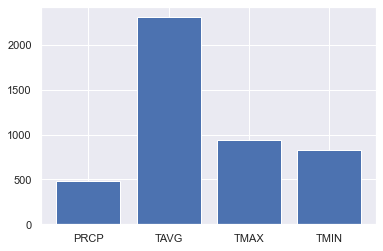

In [75]:
summary_nulls = hellinikon_data.isnull().sum().iloc[-4:]
plt.bar(summary_nulls.index, summary_nulls)

### Get the data from Hellenic Data Service

We are now able to use the same pattern(could use a function here) to get the data from the greek vendor. We will apply the same cleaning process to the new dataframe and also rename the columns.

In [76]:
# Obtain the additional data, that will help us update missing data for a specific period of time.
#original: https://data.hellenicdataservice.gr/dataset/d3b0d446-aaba-49a8-acce-e7c6f6f5d3b5/resource/a7c024b3-8606-4f08-93e2-2042f5bd6748/download/athens.csv
data = requests.get("https://auebgr-my.sharepoint.com/:x:/g/personal/p2822124_aueb_gr/EfMRKFO0cqRFhCYg9yxQj34BEX1nqCgAqTg9Xe08O0vFdA?e=8vFvvY&download=1").content
athens_dataset = pd.read_csv(io.StringIO(data.decode('utf-8')), header=None)
# drop unrelated data
athens_dataset = athens_dataset[[0, 1, 10]]
# Rename according to the description of the data here: https://data.hellenicdataservice.gr/dataset/66e1c19a-7b0e-456f-b465-b301a1130e3f/resource/a7c024b3-8606-4f08-93e2-2042f5bd6748
athens_dataset = athens_dataset.rename(columns={0: 'DATE', 1: 'TAVG', 10: 'PRCP'})
athens_dataset.head()

,DATE,TAVG,PRCP
0,2010-01-01,17.9,0.2
1,2010-01-02,15.6,0.0
2,2010-01-03,13.5,0.0
3,2010-01-04,9.5,0.0
4,2010-01-05,13.4,0.0


### Missing dates from the new series:

In [77]:
# Print the missing dates in the dataset
print(pd.date_range(
  start=hellinikon_data['DATE'].min(), end=hellinikon_data['DATE'].max()).difference(hellinikon_data['DATE']))

DatetimeIndex(['2006-01-31', '2006-02-03', '2007-08-28', '2012-05-26',
               '2012-05-27', '2012-05-28', '2012-05-31', '2012-06-01',
               '2012-06-02', '2012-06-03',
               ...
               '2017-09-10', '2017-09-20', '2017-09-21', '2017-09-23',
               '2017-09-27', '2017-10-02', '2017-10-08', '2017-10-15',
               '2017-10-27', '2018-09-17'],
              dtype='datetime64[ns]', length=856, freq=None)


We notice that 856 rows are missing.

### Null values investigation

Now, we will check this second dataset for null.

We observe that the initial view shows no nulls.

But when we try to convert the column in numeric we get some errors 

In [78]:
# no null/na s in the dataset.
print(athens_dataset.isnull().sum().iloc[-2:])

# but seems like the TAVG cannot be interpreted as numeric
print('\nAttempt to change TAVG to numeric...')
try:
    athens_dataset[["TAVG"]] = athens_dataset[["TAVG"]].apply(pd.to_numeric)
except ValueError as v:
    print(v)

TAVG    0
PRCP    0
dtype: int64

Attempt to change TAVG to numeric...
Unable to parse string "---" at position 514


Let's replace those `---` string to NaN (could use a parameter into pd.to_numeric - coerce)...

In [79]:
# replace dashes with NONE and convert to numeric
athens_dataset = athens_dataset.replace(['---'], np.NaN)
athens_dataset["TAVG"] = athens_dataset["TAVG"].apply(pd.to_numeric)
athens_dataset['DATE'] = pd.to_datetime(athens_dataset['DATE'])
athens_dataset.isnull().sum().iloc[-2:]

TAVG    3
PRCP    0
dtype: int64

We now see that we have 3 nulls in the TAVG column.

### Merge the 2 datasets

We now merge the 2 datasets using outer join.

On the resulted dataset we replace null values of the first dataset with non-null values of the second using a function.

We end up having a dataframe wit various columns (output of `info()`).

In [80]:
# merging the 2 datasets
merged = pd.merge(hellinikon_data, athens_dataset, on=['DATE'], how='outer')

# replace NAs of the first dataset with the values of the 2nd.
def replace_with(val, incomingVal):
    if(pd.notnull(val) == False and pd.notnull(incomingVal)):
        return incomingVal
    return val

merged['TAVG_x'] = merged.apply(lambda row : replace_with(row['TAVG_x'], row['TAVG_y']), axis=1)
merged['PRCP_x'] = merged.apply(lambda row : replace_with(row['PRCP_x'], row['PRCP_y']), axis=1)
merged.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24104 entries, 0 to 24103
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    24104 non-null  datetime64[ns]
 1   PRCP_x  23728 non-null  float64       
 2   TAVG_x  21792 non-null  float64       
 3   TMAX    22307 non-null  float64       
 4   TMIN    22418 non-null  float64       
 5   TAVG_y  3649 non-null   float64       
 6   PRCP_y  3652 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.5 MB


We are now able to remove the 2 right-ish columns and rename the first ones.

In [81]:
# drop merged duplicate cols
merged = merged.iloc[:, 0:-2]
# and restore names
merged = merged.rename(columns={'TAVG_x': 'TAVG', 'PRCP_x': 'PRCP'})

We see that we have the Min and Max values of the temperature for some days. It makes sense to use them in order to extract the average daily temperature for the available days.

We then are able to keep only the columns used for an further analysis and visualization.

In [82]:
# replace NA avg with mean of min-max

def replace_na_with_mean_of(val, x, y):
    if(pd.notnull(val) == False and (pd.notnull(x) and pd.notnull(y))):
        return np.mean([x,y])
    return val

merged['TAVG'] = merged.apply(lambda row : replace_na_with_mean_of(row['TAVG'], row['TMIN'], row['TMAX']), axis=1)
merged = merged[["DATE", "PRCP", "TAVG"]]

PRCP is measured in millimeters

### Final analysis

On the final dataset we will set the index to be the DATE column.

We see that the output looks correct.

We also check the completeness using the `info` function on the DataFrame.

In [83]:
merged.set_index(['DATE'], inplace=True)
print(merged.head())
print('\n-------------------------------------')
print('\nLook at the nulls...')
merged.info()

            PRCP   TAVG
DATE                   
1955-01-01   0.0  14.35
1955-01-02   2.0  10.70
1955-01-03   0.0  12.70
1955-01-04   0.0  13.05
1955-01-05   0.0  13.15

-------------------------------------

Look at the nulls...
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24104 entries, 1955-01-01 to 2018-09-17
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRCP    23728 non-null  float64
 1   TAVG    24102 non-null  float64
dtypes: float64(2)
memory usage: 564.9 KB


## Question 2

### Data preparation

We will work with an aggregated DataFrame that is grouped by year.

We then calculate a new column with the 10 years rolling average and filtering the dataset to the targeted years.

Our x-axis for the plot is the dataset's index and on y-axis we calculate the distance from the mean of the `TAVG` column.

We also setup the line to be the distance from the mean of the calculated rolling average.

In [84]:
q2_data = pd.DataFrame(merged.groupby(merged.index.year)['TAVG'].agg('mean'))
q2_data['10yrs_rolling_avg'] = q2_data['TAVG'].rolling(window=10).mean()
q2_data = q2_data.loc['1974':'1999']
# Data
x = q2_data.index
mean = q2_data['TAVG'].mean()
y = q2_data['TAVG'] - mean
line = q2_data['10yrs_rolling_avg'] - q2_data['10yrs_rolling_avg'].mean()

### Plotting

We are now able to plot the data.

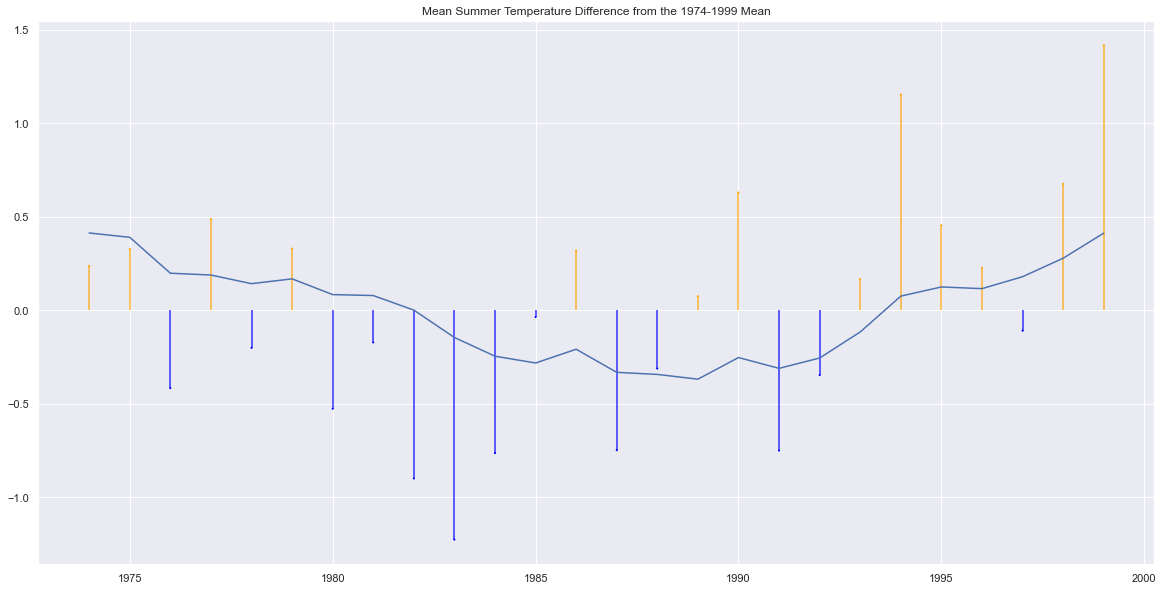

In [85]:
sns.set({'figure.figsize':(20,10)})
sns.set_theme()

# Create a color if the y axis value is equal or greater than 0
my_color = np.where(y>=0, 'orange', 'blue')
 
# The vertical plot is made using the vline function
plt.vlines(x=x, ymin=0, ymax=y, color=my_color, alpha=.8)
plt.scatter(x, y, color=my_color, s=1, alpha=1)
plt.plot(line)
# Add title and axis names
plt.title("Mean Summer Temperature Difference from the 1974-1999 Mean", loc='center')
plt.xlabel('')
plt.ylabel('')

# Show the graph
plt.show()

## Question 3

For this plot we will start from an aggregated by Month and Day dataset. Then we introduce a fake column which is the month-day info and we set it up to be of type `datetime` using 2020 us the year. That will let us setup any possible (month, day) pair, because it is itself a leap year.

We also setup a frame which has the tuple (year, month, day) as the index. It essentially provides the same info as the initial one.

On that we calculate the 30 days rolling average with tolerance to the periods used in each row calculation, so that all the rows have a value.

We then wrap the frame into a pivot table, which has as index the month and the day of the month, the rolling average as value and as pivot columns the year.(Output of the snippet below)

In [86]:
avg_by_month_day = pd.DataFrame(merged.groupby([merged.index.month, merged.index.day])['TAVG'].agg('mean'))
avg_by_month_day.index.rename(['month', 'day_of_month'], inplace=True)
avg_by_month_day['DATE_dump'] = avg_by_month_day.index.map(lambda x: datetime(2020, x[0], x[1]))


avg_by_year_day = pd.DataFrame(merged.groupby([merged.index.year, merged.index.month, merged.index.day])['TAVG'].agg('mean'))
avg_by_year_day['30days_rolling_avg'] = avg_by_year_day['TAVG'].rolling(window=30, min_periods=1).mean()
avg_by_year_day.index.rename(['year', 'month', 'day_of_month'], inplace=True)
avg_by_year_day = pd.pivot_table(avg_by_year_day, index=['month', 'day_of_month'], values=['30days_rolling_avg'], columns=['year'])
avg_by_year_day.set_index(avg_by_year_day.index.map(lambda x: datetime(2020, x[0], x[1])), inplace=True)
avg_by_year_day.head()

30days_rolling_avg                                              \
year                     1955       1956       1957       1958       1959   
2020-01-01          14.350000  13.298333  10.795000  11.503333  12.963333   
2020-01-02          12.525000  13.405000  10.641667  11.770000  13.055000   
2020-01-03          12.583333  13.396667  10.521667  12.020000  13.205000   
2020-01-04          12.700000  13.373333  10.375000  12.243333  13.411667   
2020-01-05          12.790000  13.341667  10.211667  12.346667  13.463333   

                                                                   ...  \
year             1960       1961       1962       1963       1964  ...   
2020-01-01  13.050000  15.098333  12.366667  11.560000  13.426667  ...   
2020-01-02  12.720000  15.025000  12.283333  11.630000  13.430000  ...   
2020-01-03  12.413333  14.991667  12.320000  11.703333  13.326667  ...   
2020-01-04  12.230000  14.956667  12.220000  11.920000  13.110000  ...   
2020-01-05  12.063333  14.945000  12.033333  12.110000  12.800000  ...   

                                                                              \
year             2011       2012       2013       2014       2015       2016   
2020-01-01  13.093333  12.683333  11.316667  10.473333  12.626667  10.896667   
2020-01-02  12.806667  12.560000  11.186667  10.516667  12.116667  10.670000   
2020-01-03  12.530000  12.426667  11.216667  10.620000  11.746667  10.600000   
2020-01-04  12.410000  12.266667  11.190000  10.676667  11.580000  10.650000   
2020-01-05  12.340000  12.020000  11.143333  10.713333  11.223333  10.820000   

                                                       
year            2017       2018       2019       2020  
2020-01-01  8.996667  11.960000  10.713333  12.340000  
2020-01-02  8.806667  11.806667  10.606667  12.106667  
2020-01-03  8.726667  11.693333  10.446667  11.983333  
2020-01-04  8.730000  11.650000  10.210000  11.960000  
2020-01-05  8.830000  11.710000  10.020000  11.916667  

[5 rows x 66 columns]

### Plot

We now setup the axis, we format them as needed (with dates) - some manual formatting needed to be done for the X axis.

We also set the palette to oranges, the number of color is the same as the columns in the pivoted table(years) with some tolerance to avoid dark colors.

<ipython-input-87-be9831b5d690>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=pd.unique(list(avg_by_month_day['DATE_dump'].map(lambda x: x.strftime("%b")))))


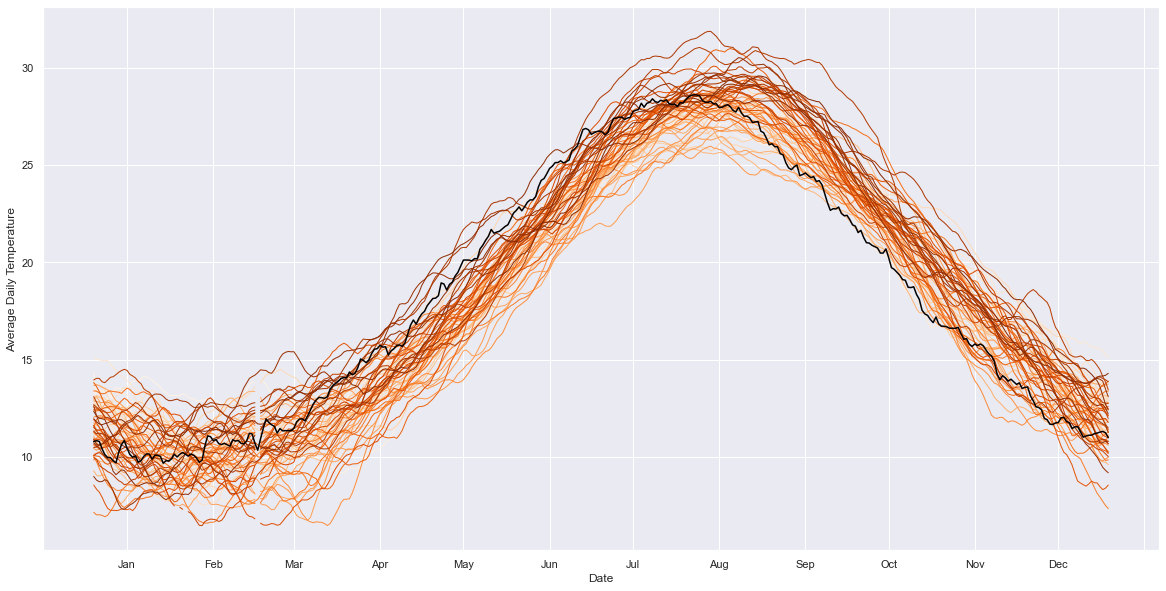

In [87]:
major_monthly_locator = mdates.MonthLocator(bymonthday=13)
major_monthly_formatter = mdates.DateFormatter('%b')
fig, ax = plt.subplots()
X = ax.xaxis
X.set_major_locator(major_monthly_locator)
X.set_major_formatter(major_monthly_formatter)
ax.set_xticklabels(labels=pd.unique(list(avg_by_month_day['DATE_dump'].map(lambda x: x.strftime("%b"))))) 

palette = sns.color_palette('Oranges', n_colors=avg_by_year_day.columns.size+2)

cmap = ListedColormap(palette)

num=0
for column in avg_by_year_day.columns:
    num+=1
    plt.plot(avg_by_month_day['DATE_dump'], avg_by_year_day[column], marker='', color=cmap(num), linewidth=1, alpha=1, label=column)

plt.plot(avg_by_month_day['DATE_dump'], avg_by_month_day['TAVG'], color='black')

plt.xlabel('Date')
plt.ylabel('Average Daily Temperature')

plt.show()

## Question 4

### Data

- We now setup the dataset to have (year, month, day) as the index.

- We set up a second dataset that will hold the baseline data for the period 1974-1999.
    - That will be further grouped by the month and day columns (could be done with pivot as well).
    - Now we have the baseline dataset
- We merge the 2 dataset with left join on the two columns month and day_of_month.
- On the merged dataset, we calculate whether the day is extreme using the function `y = temp > 1.1 * temp_baseline`, and we attach it to the dataset in the `is_extreme_event` column.
- We now setup the `by_year` frame which groups the resulted frame by year, this time we need the count in addition to the mean of TAVG column.

- We again merge the resulted dataset and the `by_year` frame (first table in the output below).

The only thing left is to aggregate by year and get the sum of extreme events. sum function on the grouped by year frame works fine in this case. 
We are now ready to calculate percentages for these data, these percentages will be plotted in the graph.

Percentages are calculated for the actual years and for the baseline range.
**Now we have the data needed to draw the bars**


In [88]:
avg_by_day = pd.DataFrame(merged.groupby([merged.index.year, merged.index.month, merged.index.day])['TAVG'].agg('mean'))
avg_by_day.index.rename(['year', 'month', 'day_of_month'], inplace=True)

baseline_data = avg_by_day[avg_by_day.index.get_level_values(0).isin(range(1974, 2000))]
avg_by_day_baseline = pd.DataFrame(baseline_data
                                    .groupby([
                                                baseline_data.index.get_level_values(1), 
                                                baseline_data.index.get_level_values(2)])['TAVG']
                                    .agg('mean'))
avg_by_day_baseline.index.rename(['month', 'day_of_month'], inplace=True)
avg_by_day['year'] = avg_by_day.index.get_level_values(0)
avg_by_day = pd.merge(avg_by_day, avg_by_day_baseline, how='left', on=['month', 'day_of_month'], suffixes=['', '_baseline'])

def is_extreme_day(val, compare):
    return val > 1.1 * compare

avg_by_day['is_extreme_event'] = avg_by_day.apply(lambda row: is_extreme_day(row['TAVG'], row['TAVG_baseline']), axis=1)

by_year = pd.DataFrame(avg_by_day.groupby(['year'])['TAVG'].agg(['mean', 'count']))
avg_by_day = pd.merge(avg_by_day, by_year, on=['year'], how='left')
print('TAVG by year')
print(avg_by_day.head())
print('-----------------------------------------------------------')
extremes_by_year = pd.DataFrame(avg_by_day.groupby(['year'])['is_extreme_event'].agg(['sum']))
extremes_by_year = pd.merge(extremes_by_year, by_year, on=['year'])
# 74 99
extreme_events_74_99 = extremes_by_year[extremes_by_year.index.isin(range(1974, 2000))]
# end of 74 99

extremes_by_year['pct'] = extremes_by_year['sum']/extremes_by_year['count']
extremes_by_year['75_99_baseline'] = extreme_events_74_99['sum'].sum()/extreme_events_74_99['count'].sum()
print('Final: percent of extreme events and baseline percent.')
print(extremes_by_year.head())

TAVG by year
    TAVG  year  TAVG_baseline  is_extreme_event      mean  count
0  14.35  1955      10.365385              True  18.79411    365
1  10.70  1955      10.707692             False  18.79411    365
2  12.70  1955      10.207692              True  18.79411    365
3  13.05  1955       9.634615              True  18.79411    365
4  13.15  1955       9.919231              True  18.79411    365
-----------------------------------------------------------
Final: percent of extreme events and baseline percent.
        sum       mean  count       pct  75_99_baseline
year                                                   
1955  128.0  18.794110    365  0.350685        0.248315
1956  113.0  18.151366    366  0.308743        0.248315
1957  116.0  18.410714    364  0.318681        0.248315
1958  130.0  18.710959    365  0.356164        0.248315
1959   96.0  17.925890    365  0.263014        0.248315


### Plot

We now draw the percentages and the baseline. We color the bars as requested.

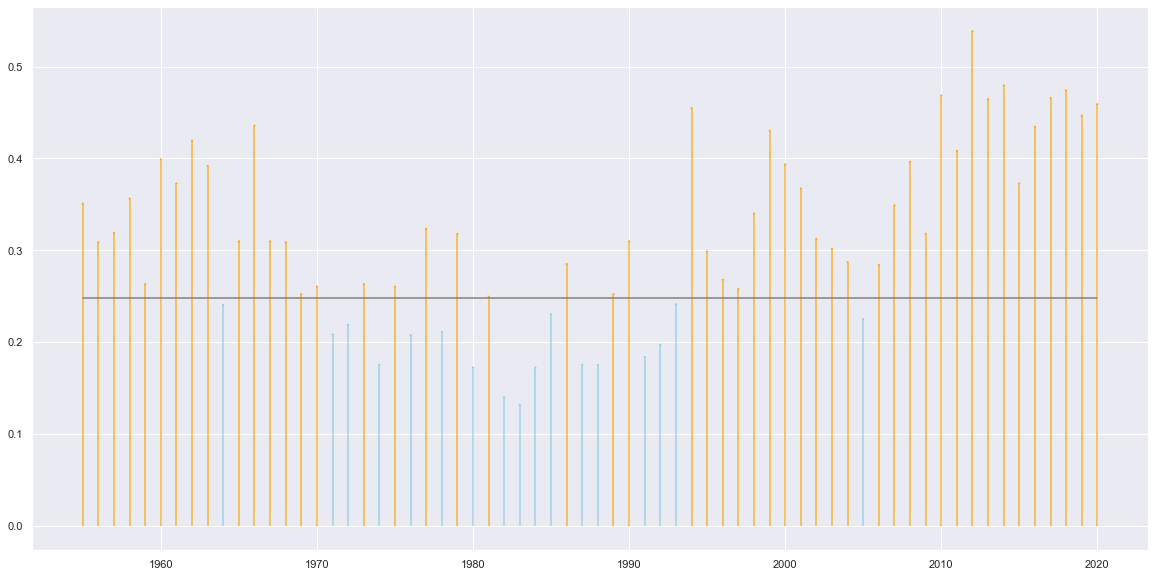

In [89]:
sns.set({'figure.figsize':(20,10)})
sns.set_theme()

x = extremes_by_year.index
y = extremes_by_year['pct']
# Create a color if the y axis value is equal or greater than 0
my_color = np.where(y>=extremes_by_year['75_99_baseline'], 'orange', 'skyblue')

# The vertical plot is made using the vline function
plt.vlines(x=x, ymin=0, ymax=y, color=my_color, alpha=.8)
plt.scatter(x, y, color=my_color, s=1, alpha=1)
plt.plot(extremes_by_year['75_99_baseline'], color='grey')

# Show the graph
plt.show()

## Question 5


### Data

We will again use the tuple of (year, month, day) as the index but this time we will need only the PRCP column to be aggregated by the mean. (essentially the same frame with a slightly different representation)

We calculate the column `has_rain` by looking whether the PRCP is greater than 0.

We now setup a frame that is aggregated by year and has the sum of PRCP and the days of rain in its columns.

We also calculate the bursts. That is the aggregated PRCP value divided by the aggregated has_rain value.

We also calculate the 10 years rolling average for the bursts and we are ready to plot.

*Sample output below.*

In [90]:
avg_by_day = pd.DataFrame(merged.groupby([merged.index.year, merged.index.month, merged.index.day])['PRCP'].agg('mean'))
avg_by_day.index.rename(['year', 'month', 'day_of_month'], inplace=True)

avg_by_day['has_rain'] = avg_by_day['PRCP'] > 0

q5_data = pd.merge(pd.DataFrame(avg_by_day.groupby(['year'])['PRCP'].agg('sum')),
                    pd.DataFrame(avg_by_day.groupby(['year'])['has_rain'].agg('sum')),
                    on='year')
q5_data['bursts'] = q5_data['PRCP']/q5_data['has_rain']

q5_data['10yrs_burst_rolling_avg'] = q5_data['bursts'].rolling(window=10, min_periods=1).mean()

q5_data.head()

,PRCP,has_rain,bursts,10yrs_burst_rolling_avg
year,,,,
1955,547.0,68.0,8.044118,8.044118
1956,281.3,52.0,5.409615,6.726867
1957,303.2,73.0,4.153425,5.869053
1958,350.0,68.0,5.147059,5.688554
1959,214.0,62.0,3.451613,5.241166


### Plot

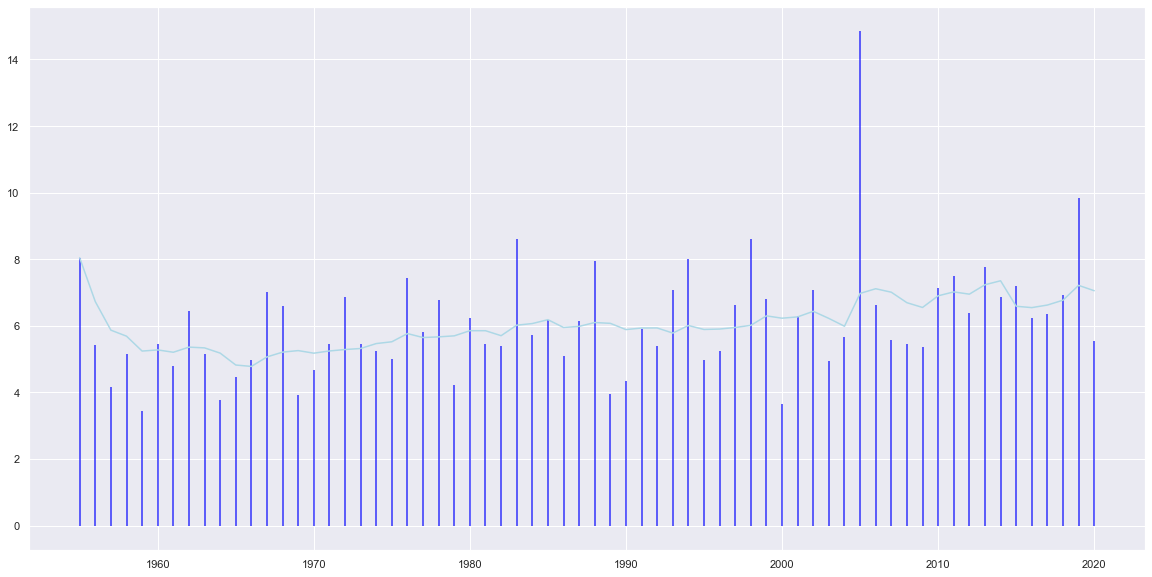

In [91]:
x = q5_data.index
y = q5_data['bursts']

# The vertical plot is made using the vline function
plt.vlines(x=x, ymin=0, ymax=y, color='blue', alpha=.8)
plt.plot(q5_data['10yrs_burst_rolling_avg'], color='lightblue')

# Show the graph
plt.show()